In [1]:
import numpy as np
import math as mt
import matplotlib.pyplot as plt
import corner
import scipy 

# Sección de funciones usadas:

El modelo que se ajustará a los datos es:

\begin{equation}
y = ax+b
\end{equation}


In [2]:
#Modelo
def recta(x,a,b):
    return a*x + b

### Función para minimizar la chi cuadrada con sólo dos parametros

En este caso trabajaremos con menos el logaritmo del likelihood:

\begin{equation}
    -\ln{p(\vec{x},\vec{y},\vec{\theta})} \propto \frac{1}{2}\sum_n \frac{(y_n - \lambda (x_n,\vec{\theta}))^2}{\sigma_n^2}
\end{equation}

donde:

\begin{equation}
    \lambda(x_n,\vec{\theta}) = ax_n +b
\end{equation}

Es el modelo al que ajustaremos los datos.

In [3]:
#Funcion para calcular la chi cuadrada
def chisq(theta,data):
    #Nuestros datos
    x = data[0]
    y = data[1]
    y_err = data[2]
    #Modelo a ajustar
    model = recta(x,theta[0],theta[1])
    #Calculamos la chi cuadrada
    chisq = (y-model)**2 / y_err**2
    #Sumamos para encontrar el menos logaritmo del likelihood
    return chisq.sum()

In [4]:
#Hacemos el método de Metropolis con varios caminadores 
def metrop_1(a_ini,b_ini,data,sigm):
    np.random.seed(1)
    #Reordenamos el arreglo de a y b iniciales.
    a_ini = a_ini.T.reshape((len(a_ini),1))
    b_ini = b_ini.T.reshape((len(b_ini),1))
    data = np.array(data)
    
    ch_ini = [] #iniciamos lista para los valores de chi iniciales.
    
    #Llenamos chi_ini con los valores iniciales 
    for i in range(len(a_ini)):
        ch_ini.append(chisq([a_ini[i][0],b_ini[i][0]],data))
    
    #Transformamos a_ini de array a list para usar la función append.
    a = a_ini.tolist()
    b = b_ini.tolist()
    
    for i in range(len(a_ini)):
        ch_0 = ch_ini[i]
        k = 0
        for j in range(10000): 
            a_af = np.random.normal(a[i][k],sigm) #creamos un valor de a y b aleatorios
            b_af = np.random.normal(b[i][k],sigm) #calculamos el menos logaritmo del likelihood de para los parametros aleatorios
            ch = chisq([a_af,b_af],data)
            if ch < ch_0: #Comparamos las dos dos logaritmos 
                a[i].append(a_af) #guardamos los parametros creados 
                b[i].append(b_af)
                k = k+1
                ch_0 = ch # si el nuevo logaritmo es es menor que el anterior lo tomamos como el nuevo
            else:
                r = -np.log(np.random.uniform(0,1)) #creamos un valor aleatorio entre 0 y 1 
                diff = abs(ch-ch_0) 
                if diff<r: #Si la diferencia entre los logaritmos (anterior y nuevo) es menor al dicho valor 
                    a[i].append(a_af) 
                    b[i].append(b_af)
                    k = k+1
                    ch_0 = ch #Tomamos el nuevo logaritmo
                else: #si la direfencia es mayor, sólo guardamos los valores de a y b creados
                    a[i].append(a[i][k])
                    b[i].append(b[i][k])
                    k = k+1
            

    # Parte de grafico
    plt.figure(figsize=(8,6))    
    
    #Gráfica de todos los pares de valores a y b creados
    for i in range(len(a_ini)):     
        plt.scatter(a[i],b[i],s=1)
    plt.ylabel('b',fontsize=18)
    plt.xlabel('a',fontsize=18)
    plt.title("Varios Caminadores",fontsize=18)
    
    return a, b

In [17]:
#Función para solo tomar el cumulo de los caminadores y graficarlos con sus histograma
def flags_data_1(a,b,flags):
    a_flg = np.array([])
    b_flg = np.array([])
    for i in range(len(a_ini)): 
        a_flg = np.append(a_flg,a[i][flags:]) #Solo tomamos los valores de los parametros por arriba del número flags 
        b_flg = np.append(b_flg,b[i][flags:])
    
    flgs = np.array([a_flg,b_flg])
    n = len(flgs)
    m = []
    mp = []
    titulo = ['Histograma de a', 'Histograma de b']
    
    #Sección para graficar:
    plt.figure(figsize=(10,10))  
    for i in range(n):
        for j in range(i+1):
            k = i-j
            if i == k:
                plt.subplot(n,n,((i*n)+k+1))
                hist = plt.hist(flgs[k], bins=20,facecolor='grey',alpha = 0.8)
                m.append(np.mean(hist[1]))
                mp.append(np.mean(hist[1]))
                plt.axvline(m[i],color='r',label = np.round(m[i],4))
                plt.title(titulo[i],fontsize=18)
                plt.legend();
            else:
                plt.subplot(n,n,((i*n)+k+1))
                plt.hexbin(flgs[k], flgs[i], gridsize=30, cmap='Greys')
                plt.axvline(m[k],color='r',label = np.round(m[k],4))
                plt.axhline(m[i],color='b',label = np.round(m[i],4))
                plt.legend();
    
    return a_flg , b_flg, m

### Función para minimizar la chi cuadrada con 3 parametros y el prior

En este caso trabajaremos con el logaritmo del likelihood:

\begin{equation}
    \ln{p(\vec{x},\vec{y},\vec{\theta})} \propto -\frac{1}{2}\sum_n \left[ \frac{(y_n - \lambda (x_n,\vec{\theta}))^2}{s_n^2} + \ln{(2\pi s_n^2)} \right]
\end{equation}

donde:

\begin{equation}
    \lambda(x_n,\vec{\theta}) = ax_n +b
\end{equation}

Es el modelo al que ajustaremos los datos.

Ademas:

\begin{equation}
    s_n^2 = \sigma_n^2 + f^2(ax_n + b)^2
\end{equation}

siendo, f un parametro extra que se calculará.

In [18]:
#Funcion para calcular la chi cuadrada con otro parametro f
def chisq_2(theta,data):
    m, b, f = theta
    #Nuestros datos
    x, y, yerr = data
    #Modelo a ajustar
    model = m * x + b
    sigma2 = yerr**2 + f**2*model**2
    #Sumamos para encontrar el logaritmo del likelihood
    return -0.5*np.sum((y-model)**2/sigma2 + np.log(sigma2)) #En este caso si influye la normalización ya que la sigma irá cambiando 

In [19]:
# Prior
def log_prior(theta):
    m, b, log_f = theta
    if -10.0 < m < 0.0 and 0.0 < b < 10.0 and -10.0 < log_f < 10.0:
        return 0.0
    return -np.inf

In [20]:
def metrop_2(a_ini,b_ini,f_ini,data,sigm):
    np.random.seed(1)
    #Reordenamos el arreglo de a y b iniciales.
    a_ini = a_ini.T.reshape((len(a_ini),1))
    b_ini = b_ini.T.reshape((len(b_ini),1))
    f_ini = f_ini.T.reshape((len(f_ini),1))
    data = np.array(data)
    
    ch_ini = [] #iniciamos lista para los valores de chi iniciales.
    
    #Llenamos chi_ini con los valores iniciales 
    for i in range(len(a_ini)):
        ch_ini.append(chisq_2([a_ini[i][0],b_ini[i][0],f_ini[i][0]],data)
                      + log_prior([a_ini[i][0],b_ini[i][0],f_ini[i][0]])) #prior
    
    #Transformamos a_ini de array a list para usar la función append.
    a = a_ini.tolist()
    b = b_ini.tolist()
    f = b_ini.tolist()
    
    for i in range(len(a_ini)):
        ch_0 = ch_ini[i] 
        k = 0
        for j in range(100000): 
            a_af = np.random.normal(a[i][k],sigm) #creamos un valor de a y b aleatorios
            b_af = np.random.normal(b[i][k],sigm) #calculamos el logaritmo del likelihood de para los parametros aleatorios
            f_af = np.random.normal(f[i][k],sigm) 
            ch = chisq_2([a_af,b_af,f_af],data) + log_prior([a_af,b_af,f_af])
            if ch > ch_0: #Comparamos las dos dos logaritmos 
                a[i].append(a_af) #guardamos los parametros creados 
                b[i].append(b_af)
                f[i].append(f_af)
                k = k+1
                ch_0 = ch # si el nuevo logaritmo es es mayor que el anterior lo tomamos como el nuevo
            else:
                r = -np.log(np.random.uniform(0,1)) 
                diff = abs(ch-ch_0)
                if diff<r: #Si la diferencia entre los logaritmos (anterior y nuevo) es menor al dicho valor
                    a[i].append(a_af)
                    b[i].append(b_af)
                    f[i].append(f_af)
                    k = k+1
                    ch_0 = ch #Tomamos el nuevo logaritmo
                else:  #si la direfencia es mayor, sólo guardamos los valores de a y b creados
                    a[i].append(a[i][k]) 
                    b[i].append(b[i][k])
                    f[i].append(f[i][k])
                    k = k+1
            

    # Parte de grafico
    plt.figure(figsize=(8,6))    
    
    #Gráfica de todos los puntos
    for i in range(len(a_ini)):     
        plt.scatter(a[i],b[i],s=1)
    plt.ylabel('b',fontsize=18)
    plt.xlabel('a',fontsize=18)
    plt.title("Varios Caminadores",fontsize=18)
    return  a, b, f

In [31]:
#Función para solo tomar el cumulo de los caminadores 
def flags_data_2(a,b,f,flags):
    a_flg = np.array([])
    b_flg = np.array([])
    f_flg = np.array([])
    for i in range(len(a_ini)): 
        a_flg = np.append(a_flg,a[i][flags:]) #Solo tomamos los valores de los parametros por arriba del número flags 
        b_flg = np.append(b_flg,b[i][flags:])
        f_flg = np.append(f_flg,f[i][flags:])
    
    flgs = np.array([a_flg,b_flg,f_flg])
    n = len(flgs)
    m = []
    mp = []
    titulo = ['Histograma de a', 'Histograma de b', 'Histograma de f']
    
    #Sección para graficar:
    plt.figure(figsize=(16,16))  
    for i in range(n):
        for j in range(i+1):
            k = i-j
            if i == k:
                plt.subplot(n,n,((i*n)+k+1))
                hist = plt.hist(flgs[k], bins=20,facecolor='grey',alpha = 0.5)
                m.append(np.mean(hist[1]))
                mp.append(np.mean(hist[1]))
                plt.axvline(m[i],color='r',label = np.round(m[i],4))
                plt.title(titulo[i],fontsize=18)
                plt.legend();
            else:
                plt.subplot(n,n,((i*n)+k+1))
                #plt.scatter(flgs[k],flgs[i],s=1)
                plt.hexbin(flgs[k], flgs[i], gridsize=30, cmap='Greys')
                plt.axvline(m[k],color='r',label = np.round(m[k],4))
                plt.axhline(m[i],color='b',label = np.round(m[i],4))
                plt.legend();
    
    return a_flg , b_flg, f_flg, m

# Sección de implementación del metodo 

## Para dos parametros

In [22]:
#Cargamos los datos
datos = np.load('fit_ejercise.npy')

In [23]:
# Acomodamos los datos en arreglos diferentes
x = datos[0]
y = datos[1]
y_err = datos[2] #error de los datos

Text(0,0.5,'y')

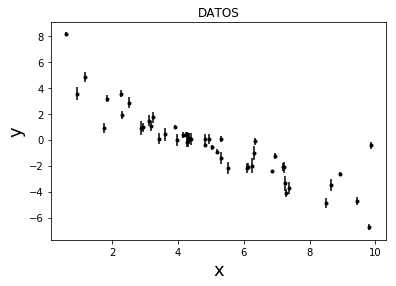

In [24]:
#Graficamos los datos para observar su comportamiento 
plt.errorbar(x,y,yerr=y_err, fmt='k.',ecolor='black')
plt.title("DATOS")
plt.xlabel("x",fontsize=18)
plt.ylabel("y",fontsize=18)

Procedemos a implementar el metodo MCMC con un modelo lineal $y = ax+b$ con sólo dos parametrso 

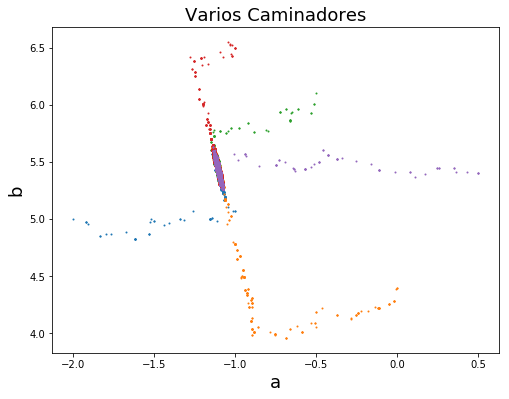

In [25]:
data = [x,y,y_err]
sigma = 0.05
a_ini = np.array([-2.0,0.0,-0.5,-1,0.5])
b_ini = np.array([5.0,4.4,6.1,6.5,5.4])
a_1, b_1 = metrop_1(a_ini,b_ini,data,sigma)

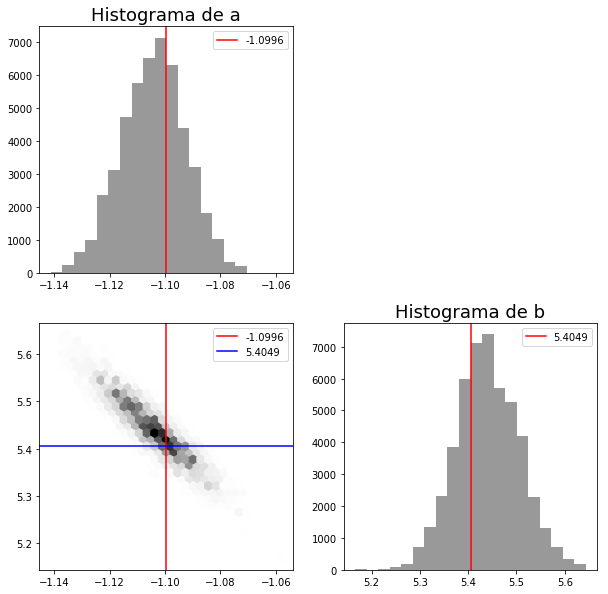

In [26]:
flags = 200
a_flg_1, b_flg_1, m_1 = flags_data_1(a_1,b_1,flags)

Vemos como se ve nuestro ajuste:

In [29]:
x_t_1 = np.linspace(-1,11,1000)
y_t_1  = x_t_1*m_1[0] + m_1[1]

Text(0,0.5,'y')

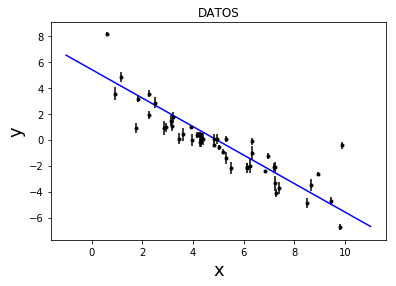

In [30]:
plt.errorbar(x,y,yerr=y_err, fmt='k.',ecolor='black')
plt.plot(x_t_1,y_t_1,'-b')
plt.title("DATOS")
plt.xlabel("x",fontsize=18)
plt.ylabel("y",fontsize=18)

## Para 3 parametros

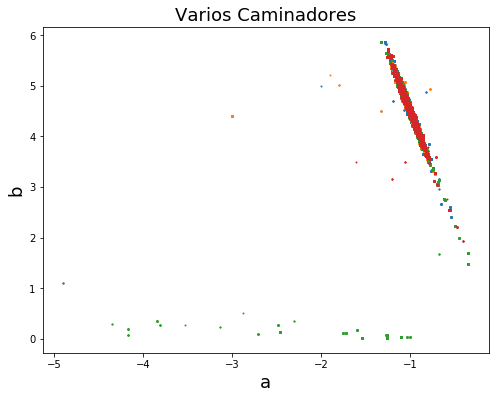

In [37]:
data = [x,y,y_err]

sigma = .5
a_ini = np.array([-2.0,-3.0,-4.9,-1.6])
b_ini = np.array([5.0,4.4,1.1,3.5])
f_ini = np.array([0.9,1.5,1,1.9,1.5])

a_2,b_2,f_2= metrop_2(a_ini,b_ini,f_ini,data,sigma)

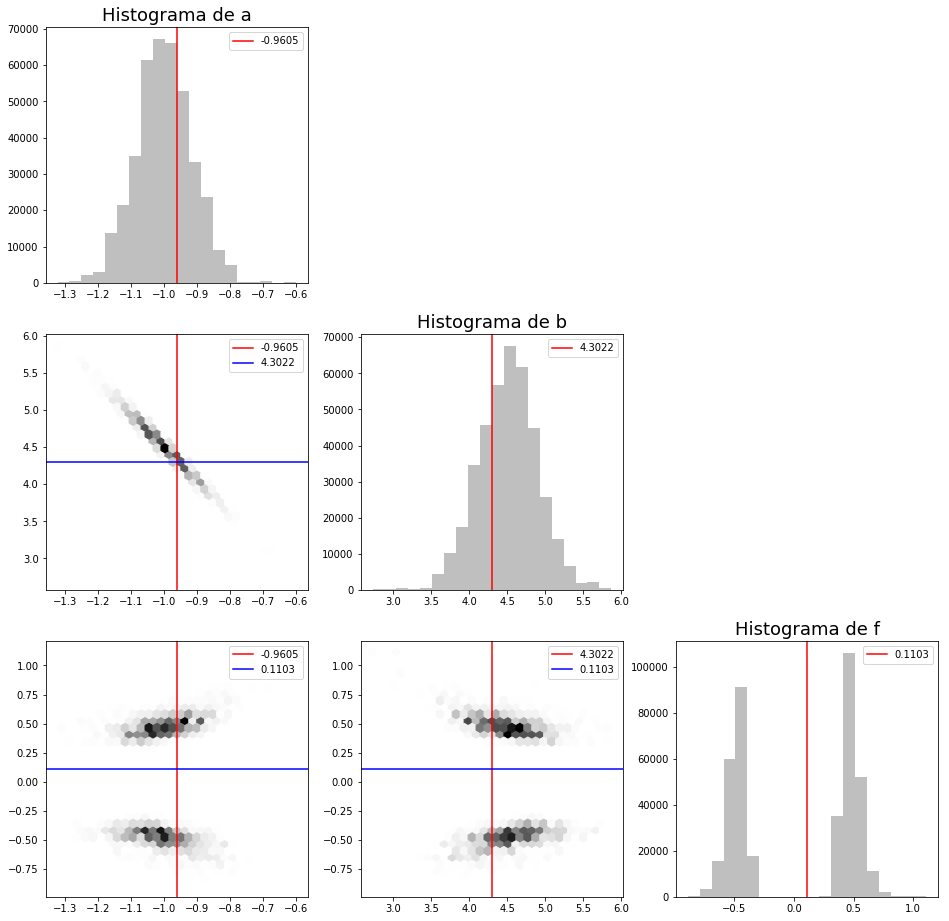

In [38]:
flags = 1000
a_flg_2,b_flg_2,f_flg_2, m_2 = flags_data_2(a_2,b_2,f_2,flags)

Vemos como se ve nuestro ajuste:

In [39]:
x_t_2 = np.linspace(-1,11,1000)
y_t_2  = x_t_2*m_2[0] + m_2[1]

Text(0,0.5,'y')

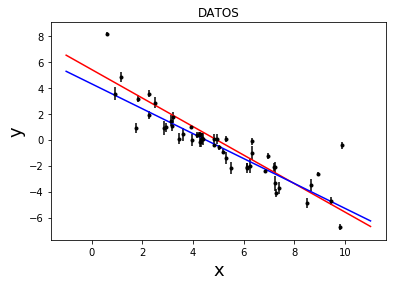

In [40]:
plt.errorbar(x,y,yerr=y_err, fmt='k.',ecolor='black')
plt.plot(x_t_1,y_t_1,'-r')
plt.plot(x_t_2,y_t_2,'-b')
plt.title("DATOS")
plt.xlabel("x",fontsize=18)
plt.ylabel("y",fontsize=18)